# Eyetracker Triggers Exploration

In [3]:
from bcipy.helpers.triggers import TriggerType, trigger_decoder, TriggerHandler, Trigger
from bcipy.helpers.raw_data import load
import matplotlib.pyplot as plt

pygame 2.1.2 (SDL 2.0.18, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Set the paths to your data

In [19]:
data_folder = "C:/Users/tabme/OneDrive/Desktop/test_serving_lsl_et_eeg/test_serving_lsl_et_eeg_RSVP_Calibration_Thu_24_Aug_2023_15hr16min09sec_-0700"
trigger_file_name = 'triggers.txt'
file_name = 'eyetracker_data_tobii_nano.csv'

### Read in trigger data

In [20]:
# Read triggers.
# 
# NOTE: that the first line in the triggers.txt file should be the starting_offset
# and that the timestamp should be set to the lsl_timestamp of the first row in the eyetracker data
# ex. starting_offset offset -799951.3024919
sample_rate = 60
offset = -.49
exclude_trigger_types = [TriggerType.PREVIEW, TriggerType.EVENT, TriggerType.FIXATION, TriggerType.PROMPT, TriggerType.SYSTEM, TriggerType.OFFSET]
targetness, timing, symbols = trigger_decoder(offset=0.0, trigger_path=f"{data_folder}/{trigger_file_name}",  exclusion=exclude_trigger_types)

# sample number in data for each trigger
triggers = list(map(lambda x: int((x + offset) * sample_rate), timing))

In [21]:
# Read in raw trigger data with the lsl_timestamps.

raw_triggers = []
with open(f"{data_folder}/{trigger_file_name}", encoding=TriggerHandler.encoding) as raw_txt:
    for i, line in enumerate(raw_txt):
        trg = Trigger.from_list(line.split())
        if trg.type not in exclude_trigger_types:
            raw_triggers.append(trg)

assert len(raw_triggers) == len(triggers), "Error reading raw_triggers"

### Read data into a dataframe

In [22]:
data = load(f"{data_folder}/{file_name}")
df = data.dataframe

### Define functions

In [23]:
def closest(dataframe, timestamp):
    """Find the closest row based on the lsl_timestamp"""
    return dataframe[dataframe['lsl_timestamp'] >= timestamp].min()

def find_sample(dataframe, sample_number):
    """Find the row based on the sample number"""
    return dataframe[dataframe['timestamp'] == sample_number].iloc[0]

In [24]:
# Test out the closest function
stamp = 800004.3112636
row = closest(df, stamp)
row['timestamp'], row['lsl_timestamp']

(nan, nan)

0.016666666666666666


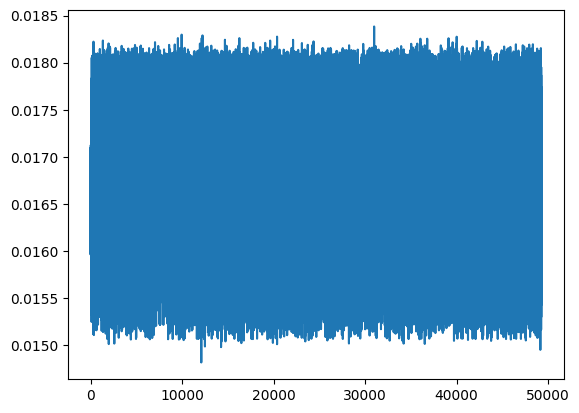

In [25]:
# compute the difference in value between all lsl_timestamps and the previous lsl_timestamp
diffs = []
prev_stamp = None
for stamp in df['lsl_timestamp']:
    if prev_stamp is None:
        prev_stamp = stamp
        continue
    diff = stamp - prev_stamp
    prev_stamp = stamp
    diffs.append(diff)

# plot the diffs
plt.plot(diffs)
# print(diffs)
print(1/sample_rate)


In [26]:
# Test find_sample function
sample = find_sample(df, 3180)
sample['timestamp'], sample['lsl_timestamp']

(3180.0, 190090.6217104)

In [27]:
triggers[0:10]

[409, 424, 440, 455, 470, 486, 501, 516, 532, 547]

In [28]:
raw_triggers[0:10]

[Trigger: label=[G] type=[nontarget] time=[190043.9399267],
 Trigger: label=[W] type=[nontarget] time=[190044.195431],
 Trigger: label=[R] type=[nontarget] time=[190044.4496874],
 Trigger: label=[M] type=[nontarget] time=[190044.7045467],
 Trigger: label=[Y] type=[nontarget] time=[190044.9603122],
 Trigger: label=[_] type=[target] time=[190045.2145699],
 Trigger: label=[O] type=[nontarget] time=[190045.4703106],
 Trigger: label=[H] type=[nontarget] time=[190045.7241949],
 Trigger: label=[S] type=[nontarget] time=[190045.9791043],
 Trigger: label=[D] type=[nontarget] time=[190046.233338]]

### Define output data structure

In [29]:
from typing import NamedTuple

class Row(NamedTuple):
    label: str
    target_type: str
    trigger_timestamp: float
    computed_sample_number: int
    computed_sample_number_timestamp: float
    closest_sample_number: float # found based on closest lsl_timestamp to trigger
    closest_sample_number_timestamp: float

### Populate data for analysis

In [30]:
import pandas as pd

data = []
for i, trg in enumerate(raw_triggers):
    try:
        sample_record = find_sample(df, triggers[i])
        closest_record = closest(df, trg.time)
        data.append({
            'label': trg.label, 
            'target_type': trg.type,
            'trigger_timestamp': trg.time,
            'computed_sample': triggers[i],
            'computed_sample_timestamp': sample_record['lsl_timestamp'],
            'closest_sample': closest_record['timestamp'],
            'closest_sample_timestamp': closest_record['lsl_timestamp']
        })
    except IndexError:
        pass

analysis_df = pd.DataFrame.from_records(data)

In [31]:
# Add computed columns
analysis_df['sample_diff'] = analysis_df.closest_sample - analysis_df.computed_sample
analysis_df['time_diff'] = analysis_df.closest_sample_timestamp - analysis_df.computed_sample_timestamp
analysis_df

,label,target_type,trigger_timestamp,computed_sample,computed_sample_timestamp,closest_sample,closest_sample_timestamp,sample_diff,time_diff
0,G,nontarget,190043.939927,409,190044.438710,380.0,190043.954365,-29.0,-0.484345
1,W,nontarget,190044.195431,424,190044.688746,395.0,190044.203964,-29.0,-0.484782
2,R,nontarget,190044.449687,440,190044.955571,410.0,190044.453885,-30.0,-0.501686
3,M,nontarget,190044.704547,455,190045.204853,425.0,190044.704735,-30.0,-0.500117
4,Y,nontarget,190044.960312,470,190045.455419,441.0,190044.971107,-29.0,-0.484312
...,...,...,...,...,...,...,...,...,...
995,Z,nontarget,190847.403402,48617,190847.905282,48587.0,190847.404689,-30.0,-0.500593
996,H,nontarget,190847.659172,48632,190848.155517,48603.0,190847.671680,-29.0,-0.483837
997,P,nontarget,190847.914084,48648,190848.421999,48618.0,190847.921612,-30.0,-0.500387
998,F,nontarget,190848.168173,48663,190848.672088,48633.0,190848.171499,-30.0,-0.500589


In [32]:
# Plot
analysis_df['time_diff'].describe()

count    1000.000000
mean       -0.493657
std         0.008158
min        -0.501804
25%        -0.500422
50%        -0.499687
75%        -0.483859
max        -0.481452
Name: time_diff, dtype: float64

<AxesSubplot:title={'center':'Time Diffs'}, xlabel='trigger number', ylabel='time diff (closest - computed)'>

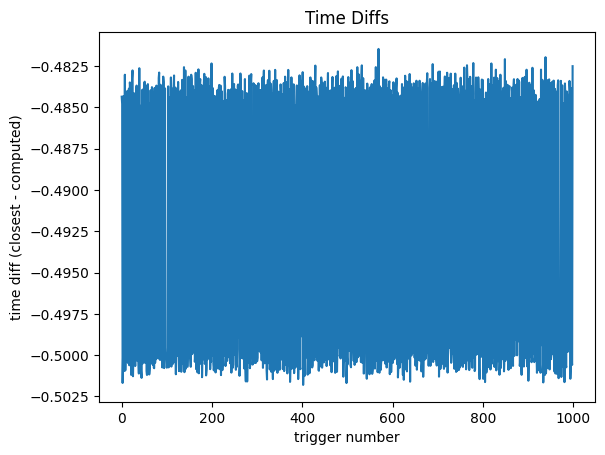

In [33]:
analysis_df['time_diff'].plot(kind='line', xlabel='trigger number', ylabel='time diff (closest - computed)', title='Time Diffs')